In [1]:
####Variable order Tensor Decompositionによる業績スコア予測エンジン開発####
import numpy as np
import pandas as pd
import matplotlib.pyplot  as plt
import numpy.matlib
import itertools
import mglearn
import scipy
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from datetime import time, datetime, timedelta
from scipy import sparse
from pandas.tools.plotting import scatter_matrix
from numpy.random import *
import re
import MeCab
import neologdn
import sys

np.random.seed(98537)

In [2]:
##データの読み込み
def data_input():
    ##データの設定
    #ニュースデータの読み込み
    input_path = "C:/statistics/data/DJ_news_data/custom_data/DJ_fulldata_new.csv"
    read_data = pd.read_csv(input_path, index_col=0)    

    #株価データの読み込み
    panel_data = pd.read_csv("C:/statistics/data/stock_price/stock_panel_data.csv", index_col=0)
    company_info = pd.read_csv("C:/statistics/data/stock_price/st-jp/company_info.csv")
    date_range = [np.min(panel_data["日付"]), np.max(panel_data["日付"])]
    
    #不要な業界を取り除く
    rid_object = np.array(["REIT", "カントリーF", "インフラF"])
    index = ~numpy.in1d(panel_data["業種"], rid_object, assume_unique=False, invert=False)
    panel_data = panel_data.iloc[index]
    return read_data, company_info, panel_data

In [3]:
##データの前処理
def data_preprocess(read_data, company_info, panel_data):
    ##分析済みのデータのみを取り出す
    index_get = np.array(np.where(np.array(pd.isna(read_data[["aiep"]])==False).reshape(-1))[0], dtype="int")
    df = read_data.iloc[index_get, ]
    df.index = np.arange(df.shape[0])
    del read_data
    
    ##単語の名寄せを行う
    #データの読み込み
    area_dic = pd.read_csv("C:/statistics/data/dic/area_pattern_freq.csv", encoding="Shift-Jis")
    item_dic = pd.read_csv("C:/statistics/data/dic/item_pattern_freq.csv", encoding="Shift-Jis")

    #辞書から単語を名寄せ
    tmp_df = df.copy()
    tmp_df = pd.merge(tmp_df, area_dic, left_on="area", right_on="input", how="left")
    tmp_df = pd.merge(tmp_df, item_dic, left_on="item", right_on="input", how="left")
    df["area"] = tmp_df["output_x"]; df["item"] = tmp_df["output_y"]
    del tmp_df
    
    #aiepがすべてnanのニュースを取り除く
    Z = np.zeros((df.shape[0], 5), dtype="int")
    Z[:, 0] = ~pd.isna(df["area"])
    Z[:, 1] = ~pd.isna(df["item"])
    Z[:, 2] = ~pd.isna(df["element"])
    Z[:, 3] = ~pd.isna(df["subject"])
    Z[:, 4] = ~pd.isna(df["trend"])
    df = df.iloc[np.where(np.sum(Z, axis=1) >= 2)[0]]
    df.index = np.arange(df.shape[0])
    
    ##データの設定
    #日付をdatetime型に変更
    df["date"] = pd.to_datetime(df["date"].str[0:19])
    panel_data["日付"] = pd.to_datetime(panel_data["日付"] + " 14:30:00")
    date_range = np.array([np.min(panel_data["日付"][panel_data["日付"] > "2010"]), np.max(panel_data["日付"])])
    #date_range = np.array([np.min(panel_data["日付"]), np.max(panel_data["日付"])])

    #ニュースのある期間のデータのみ抽出
    index1 = np.array(np.where((panel_data["日付"] > date_range[0]) & (panel_data["日付"] <= date_range[1]))[0], dtype="int")
    index2 = np.array(np.where((df["date"] > date_range[0]) & (df["date"] <= date_range[1]))[0], dtype="int")
    target_panel = panel_data.iloc[index1]
    target_df = df.iloc[index2]
    target_panel.index = np.arange(target_panel.shape[0])
    target_df.index = np.arange(target_df.shape[0])
    del panel_data
    return target_panel, target_df

In [4]:
#aiepの組み合わせの個数をカウントする
def pattern_count():
    area_vec = target_df["area"]; area_vec[pd.isna(area_vec)] = "抽出なし"
    item_vec = target_df["item"]; item_vec[pd.isna(item_vec)] = "抽出なし"
    element_vec = target_df["element"]; element_vec[pd.isna(element_vec)] = "抽出なし"
    subject_vec = target_df["subject"]; subject_vec[pd.isna(subject_vec)] = "抽出なし"
    trend_vec = target_df["trend"]; trend_vec[pd.isna(trend_vec)] = "抽出なし"
    aiep_vec = area_vec + " - " + item_vec + " - " + element_vec + " - " + subject_vec + " - " + trend_vec
    res = aiep_vec.value_counts()
    freq_df = pd.DataFrame({"pattern": np.array(res.index), "freq": np.array(res, dtype="int")})
    freq_df.to_csv("C:/statistics/data/aiep_pattern_freq.csv", sep=",")
    return freq_df

In [5]:
##ニュースソースを削減する
def delete_news(target_df):
    
    #要因の個数を集計する
    area_count = pd.Series.value_counts(target_df["area"])
    target_area = np.array((area_count[area_count >= 10].index))
    item_count = pd.Series.value_counts(target_df["item"])
    target_item = np.array((item_count[item_count >= 10].index))
    subject_count = pd.Series.value_counts(target_df["subject"])
    target_subject = np.array((subject_count[subject_count >= 10].index))
    element_count = pd.Series.value_counts(target_df["element"])
    target_element = np.array((element_count[element_count >= 10].index))

    #データフレームをサンプルする
    target1 = np.in1d(target_df["area"], target_area) | pd.isna(target_df["area"])
    target2 = np.in1d(target_df["item"], target_item) | pd.isna(target_df["item"])
    target3 = np.in1d(target_df["subject"], target_subject) | pd.isna(target_df["subject"])
    target4 = np.in1d(target_df["element"], target_element) | pd.isna(target_df["element"])
    target_df = target_df.iloc[np.array(target1 & target2 & target3 & target4)]
    target_df.index = np.arange(target_df.shape[0])

    area_count.to_csv("C:/statistics/data/area_pattern_freq.csv", sep=",")
    item_count.to_csv("C:/statistics/data/item_pattern_freq.csv", sep=",")
    subject_count.to_csv("C:/statistics/data/subject_pattern_freq.csv", sep=",")
    element_count.to_csv("C:/statistics/data/element_pattern_freq.csv", sep=",")

    ##aiepを抽出
    #カラムに含まれている要素数
    print(pd.unique(target_df["area"]).shape[0])
    print(pd.unique(target_df["subject"]).shape[0])
    print(pd.unique(target_df["item"]).shape[0])
    print(pd.unique(target_df["element"]).shape[0])
    print(pd.unique(target_df["predicate"]).shape[0])
    print(pd.unique(target_df["trend"]).shape[0])
    print(pd.unique(target_df["tags"]).shape[0])
    
    ##aiepに数値idを設定
    #ユニークな要素を抽出
    unique_area = pd.unique(target_df["area"]); area_n = unique_area.shape[0]
    unique_item = pd.unique(target_df["item"]); item_n = unique_item.shape[0]
    unique_subject = pd.unique(target_df["subject"]); subject_n = unique_subject.shape[0]
    unique_element = pd.unique(target_df["element"]); element_n = unique_element.shape[0]
    unique_trend = pd.unique(target_df["trend"]); trend_n = unique_trend.shape[0]
    unique_predicate = pd.unique(target_df["predicate"]); predicate_n = unique_predicate.shape[0]
    unique_tags = pd.unique(target_df["tags"]); tags_n = unique_tags.shape[0]

    #マスターデータにidを設定
    area_df = pd.DataFrame({"area": unique_area, "id": np.arange(area_n)})
    area_id = np.array(pd.merge(target_df[["area"]], area_df, on="area", how="left")["id"], dtype="int")

    unique_item = np.append(unique_item[~pd.isna(pd.Series(unique_item))], np.nan)
    item_df = pd.DataFrame({"item": unique_item, "id": np.arange(item_n)})
    item_id = np.array(pd.merge(target_df[["item"]], item_df, on="item", how="left")["id"], dtype="int")

    unique_subject = np.append(unique_subject[~pd.isna(pd.Series(unique_subject))], np.nan)
    subject_df = pd.DataFrame({"subject": unique_subject, "id": np.arange(subject_n)})
    subject_id = np.array(pd.merge(target_df[["subject"]], subject_df, on="subject", how="left")["id"], dtype="int")

    unique_element = np.append(unique_element[~pd.isna(pd.Series(unique_element))], np.nan)
    element_df = pd.DataFrame({"element": unique_element, "id": np.arange(element_n)})
    element_id = np.array(pd.merge(target_df[["element"]], element_df, on="element", how="left")["id"], dtype="int")

    unique_trend = np.append(unique_trend[~pd.isna(pd.Series(unique_trend))], np.nan)
    trend_df = pd.DataFrame({"trend": unique_trend, "id": np.arange(trend_n)})
    trend_id = np.array(pd.merge(target_df[["trend"]], trend_df, on="trend", how="left")["id"], dtype="int")
    return target_df, area_df, area_id, item_df, item_id, subject_df, subject_id, element_df, element_id, trend_df, trend_id

In [6]:
##ニュースデータと株価データを対応付ける
def correspond_data(target_df, target_panel, area_id, item_id, subject_id, element_id, trend_id):
    #ニュースデータの日付を市場が開いている時間に繰り越す
    index = np.array(np.where((target_df["date"].apply(lambda x:x.time()) >= time(hour=0)) & 
                              (target_df["date"].apply(lambda x:x.time()) <= time(hour=15)))[0], dtype="int")
    index_target = np.delete(np.arange(target_df.shape[0]), index)
    new_date = target_df[["date"]].copy()
    new_date["date"].iloc[index_target] = target_df["date"].iloc[index_target] + timedelta(days=1)

    #日付のデータ型を数値型に変更
    df_date = np.array((new_date["date"].dt.date.astype("str")).str.replace("-", ""), dtype="int")
    panel_date = np.array(target_panel["日付"].dt.date.astype("str").str.replace("-", ""), dtype="int")
    unique_date = np.array(np.sort(np.unique(df_date)), dtype="int")  
    date_n = unique_date.shape[0]

    #重複しているニュースを特定
    tmp_df = pd.concat((pd.DataFrame(df_date), target_df[["area", "subject", "item", "element", "trend"]]), axis=1)
    tmp_df = tmp_df.rename(columns={0: "date"})
    tmp_df = tmp_df.fillna("hoge")
    index_dup = np.array(tmp_df.duplicated())
    joint_tag = tmp_df["date"].astype("U8") + "-" + tmp_df["area"] + "-" + tmp_df["subject"] +\
                    "- " + tmp_df["item"] + "-" + tmp_df["element"] + "-" + tmp_df["trend"]
    joint_count = joint_tag.value_counts()
    pd.DataFrame({"tag": joint_count.index, "freq": np.array(joint_count, dtype="int")}).to_csv("C:/statistics/data/record_dup.csv")

    #重複を削除
    target_df = target_df.iloc[~index_dup, ]
    target_df.index = np.arange(target_df.shape[0])
    area_id = area_id[~index_dup]
    item_id = item_id[~index_dup]
    subject_id = subject_id[~index_dup]
    element_id = element_id[~index_dup]
    trend_id = trend_id[~index_dup]
    df_date = df_date[~index_dup]

    #日付ごとにニュースと株価を対応付ける
    df_index = [j for j in range(date_n)]
    panel_index = [j for j in range(date_n)]

    for j in range(date_n):
        if j%500==0:
            print(j)
        df_index[j] = np.array(np.where(df_date==unique_date[j])[0], dtype="int")
        index = np.array(np.where(panel_date==unique_date[j])[0], dtype="int")
        rp = 0
        if index.shape[0]==0:
            while True:
                rp = rp + 1
                if j + rp >= date_n:
                    break
                index = np.array(np.where(panel_date==unique_date[j+rp])[0], dtype="int")
                if index.shape[0] > 0:
                    break
        panel_index[j] = index

    #日付ごとに要素数を数える
    panel_n = np.repeat(0, date_n)
    df_n = np.repeat(0, date_n)
    for j in range(date_n):
        panel_n[j] = panel_index[j].shape[0]
        if panel_n[j] > 0:
            df_n[j] = df_index[j].shape[0]
    return target_df, area_id, item_id, subject_id, element_id, trend_id, df_date

In [7]:
##インデックスを設定
def create_index(area_id, item_id, subject_id, element_id, trend_id):
    #アイテムごとのユニーク数を数える
    area_n = np.unique(area_id).shape[0]
    item_n = np.unique(item_id).shape[0]
    subject_n = np.unique(subject_id).shape[0]
    element_n = np.unique(element_id).shape[0]
    trend_n = np.unique(trend_id).shape[0]
    
    #インデックスを定義
    index_area = [i for i in range(area_n)]
    index_item = [i for i in range(item_n)]
    index_subject = [i for i in range(subject_n)]
    index_element = [i for i in range(element_n)]
    index_trend = [i for i in range(trend_n)]
    for i in range(area_n):
        index_area[i] = np.array(np.where(area_id==i)[0], dtype="int")
    for i in range(item_n):
        index_item[i] = np.array(np.where(item_id==i)[0], dtype="int")
    for i in range(subject_n):
        index_subject[i] = np.array(np.where(subject_id==i)[0], dtype="int")
    for i in range(element_n):
        index_element[i] = np.array(np.where(element_id==i)[0], dtype="int")
    for i in range(trend_n):
        index_trend[i] = np.array(np.where(trend_id==i)[0], dtype="int")
    return index_area, index_item, index_subject, index_element, index_trend

In [8]:
def create_response_variable(target_panel):
    ##応答変数を加工
    #データの設定
    price = np.array(target_panel["終値"])
    code = np.array(target_panel["コード"], dtype="int")
    reference_id = np.array(target_panel["reference_id"], dtype="int")
    N = target_panel.shape[0]
    
    #新しいreference_idを設定
    target_company_info = company_info.iloc[np.in1d(company_info["reference_id"], np.unique(reference_id))]
    target_company_info.index = np.arange(target_company_info.shape[0])
    target_company_info = pd.concat((target_company_info, pd.DataFrame(np.arange(target_company_info.shape[0]))), axis=1)
    target_company_info = target_company_info[["reference_id", 0, "コード", "銘柄名", "取引市場", "業種", "資本金", "単元株数"]]
    target_company_info.columns = ["reference_id", "new_id", "コード", "銘柄名", "取引市場", "業種", "資本金", "単元株数"]
    
    #panel_dataのreference_idに新しいreference_idを設定
    reference_df = pd.DataFrame(reference_id)
    reference_df.columns = ["reference_id"]
    new_id = np.array(pd.merge(reference_df, target_company_info[["reference_id", "new_id"]], on="reference_id", how="left")["new_id"])
    n = np.unique(new_id).shape[0]

    #panelに新しいreference_idを結合
    target_panel = pd.concat((target_panel, pd.DataFrame(new_id)), axis=1)
    target_panel = target_panel[["reference_id", 0, "コード", "銘柄名", "業種", "日付", "終値", "出来高"]]
    target_panel.columns = ["reference_id", "new_id", "コード", "銘柄名", "業種", "日付", "終値", "出来高"]
    
    #インデックスを作成
    c_index_list = [i for i in range(n)]
    c_no_list = [i for i in range(n)]
    c_max_index = np.repeat(0, n)
    for i in range(n):
        if i%500==0:
            print(i)
        c_index_list[i] = np.array(np.where(new_id==i)[0], dtype="int")
        c_no_list[i] = np.arange(c_index_list[i].shape[0])
        c_max_index[i] = np.max(c_index_list[i])

    #リストを変換
    c_no = np.array(list(itertools.chain(*[np.array(c_no_list[i]) for i in range(n)])))
    
    ##株価の終値の変動率を算出
    #差分を算出するためのインデックス
    index_t1 = np.where(c_no==0)[0]
    index_previous = np.array(np.delete(np.arange(N), c_max_index), dtype="int")
    index_behind = np.array(np.delete(np.arange(N), index_t1), dtype="int")

    #変化率を取得
    diff_ratio = np.repeat(0.0, N)
    diff_price = np.repeat(0.0, N)
    diff_ratio[index_behind] = (price[index_behind] - price[index_previous]) / price[index_previous]
    diff_price[index_behind] = price[index_behind] - price[index_previous]
    
    #階差の移動平均を取る
    n = len(c_index_list)
    moving_average_list = [i for i in range(n)] 
    z_list = [i for i in range(n)]
    long = np.zeros((n, 2))

    for i in range(n):
        index = c_index_list[i]
        num = 5   #移動平均の個数
        b = np.ones(num) / num
        mu = np.convolve(diff_price[index], b, mode="same")   #移動平均
        if index.shape[0] < 5:
            moving_average_list[i] = mu[0:index.shape[0]]
            z_list[i] = np.repeat(0, index.shape[0])
        else:
            moving_average_list[i] = mu
            z_list[i] = np.append(np.repeat(0, mu[0:4].shape[0]), np.repeat(1, mu[4:].shape[0]))
        long[i, ] = np.array([index.shape[0], mu.shape[0]])
        
    #リストを変換
    moving_average = np.array(list(itertools.chain(*[np.array(moving_average_list[i]) for i in range(n)])))
    z = np.array(list(itertools.chain(*[np.array(z_list[i]) for i in range(n)])))
    
    #データフレームに変換
    panel_df = pd.concat([target_panel[["reference_id", "new_id", "コード", "銘柄名", "業種", "日付", "終値", "出来高"]],
                          pd.DataFrame({"diff_ratio": diff_ratio, "diff_price": diff_price, "moving_mu": moving_average,
                                       "z": z})], axis=1)
    new_df = panel_df.iloc[index_behind]
    out = "C:/statistics/data/stock_price/stock_price_diff.csv"
    #panel_df.to_csv(out, sep=",", index=False)
    return panel_df, new_df

In [9]:
##入力変数の前処理
#データの読み込み
read_data, company_info, panel_data = data_input()

#データの加工とデータの絞り込み
target_panel, target_df = data_preprocess(read_data, company_info, panel_data)
res_delete_news = delete_news(target_df)
target_df, area_df, area_id, item_df, item_id, subject_df, subject_id, element_df, element_id, trend_df, trend_id = res_delete_news
del res_delete_news

#株価データとニュースデータを対応付ける
res_correspond_data = correspond_data(target_df, target_panel, area_id, item_id, subject_id, element_id, trend_id)
target_df, area_id, item_id, subject_id, element_id, trend_id, df_date = res_correspond_data
del res_correspond_data
index_area, index_item, index_subject, index_element, index_trend = create_index(area_id, item_id, subject_id, element_id, trend_id)

C:\statistics\anaconda\lib\site-packages\IPython\core\interactiveshell.py:3185: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  if (yield from self.run_code(code, result)):
C:\statistics\anaconda\lib\site-packages\numpy\lib\arraysetops.py:522: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)
C:\statistics\anaconda\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


128
801
1061
596
570
3
28574
0
500
1000
1500
2000
2500


0
500
1000
1500
2000
2500
3000
3500


Text(0.5, 1.0, '企業毎の株価変化率の標準偏差分布')

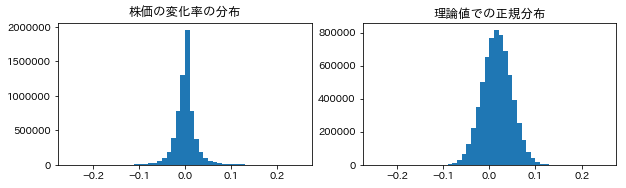

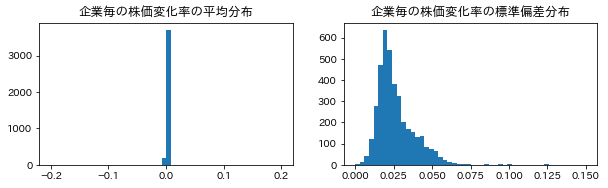

In [10]:
##応答変数の前処理
#応答変数の差分や移動平均を取る
panel_df, new_df = create_response_variable(target_panel)

##分布を可視化
#株価の変化率を可視化
N = panel_df.shape[0]
y = np.array(panel_df["diff_ratio"])
mu = np.mean(np.abs(y))
sd = np.std(np.abs(y)) 
fig = plt.figure(figsize=(10.0, 6.0))
plt.subplots_adjust(wspace=0.2, hspace=0.3)   #余白を設定
ax = fig.add_subplot(2, 2, 1)
ax.hist(y, range=(-0.25, 0.25), bins=50)   #変化率のヒストグラム
plt.title("株価の変化率の分布", fontsize=12.5)
ax = fig.add_subplot(2, 2, 2)
ax.hist(np.random.normal(mu, sd, N), range=(-0.25, 0.25), bins=50)
plt.title("理論値での正規分布", fontsize=12.5)

#グループごとの集計値の可視化
N1 = new_df.shape[0]
new_df.index = np.arange(N1)
grouped = new_df.groupby("銘柄名")

#企業毎の集計値をヒストグラムにする
fig = plt.figure(figsize=(10.0, 6.0))
plt.subplots_adjust(wspace=0.2, hspace=0.3)   #余白を設定
ax = fig.add_subplot(2, 2, 1)
ax.hist(np.array(grouped[["diff_ratio"]].mean()).reshape(-1), range=(-0.2, 0.2), bins=50)
plt.title("企業毎の株価変化率の平均分布", fontsize=12.5)
ax = fig.add_subplot(2, 2, 2)
ax.hist(np.array(grouped[["diff_ratio"]].std()).reshape(-1), range=(0, 0.15), bins=50)
plt.title("企業毎の株価変化率の標準偏差分布", fontsize=12.5)

In [11]:
####aiepのid配置を割り当て####
##ニュースソースのaiepをグループごとにデータフレームに格納
#日付の連番idを作成
unique_date = np.unique(df_date); date_n = unique_date.shape[0]
co_date = pd.DataFrame(df_date); co_date.columns = ["date"]
date_table = pd.DataFrame({"date": unique_date, "id": np.arange(date_n)})
date_id = pd.merge(co_date, date_table, on="date", how="left")

In [12]:
#パネルの日付をint型に変換
tmp_date = new_df["日付"].astype("str")
tmp_date = tmp_date.str[0:10].str.replace("-", "").astype("int")
new_date = pd.merge(pd.DataFrame(tmp_date), date_table, left_on="日付", right_on="date", how="left")
index_date = np.array(np.where(~pd.isna(new_date["date"]))[0], dtype="int")
new_date = new_date.iloc[index_date]
new_panel = new_df.iloc[index_date]
new_date["date"] = np.array(new_date["date"], dtype="int")
new_date["id"] = np.array(new_date["id"], dtype="int")
new_date = new_date[["date", "id"]]
new_date.index = np.arange(new_date.shape[0]); new_panel.index = np.arange(new_panel.shape[0])

In [13]:
##aiepのidをすべて結合したデータフレームを作成
#結合idを定義
area_dt = pd.DataFrame({"id": area_id})
area_dt = pd.merge(area_dt, area_df, on="id", how="left")
item_dt = pd.DataFrame({"id": item_id})
item_dt = pd.merge(item_dt, item_df, on="id", how="left")
element_dt = pd.DataFrame({"id": element_id})
element_dt = pd.merge(element_dt, element_df, on="id", how="left")
subject_dt = pd.DataFrame({"id": subject_id})
subject_dt = pd.merge(subject_dt, subject_df, on="id", how="left")
trend_dt = pd.DataFrame({"id": trend_id})
trend_dt = pd.merge(trend_dt, trend_df, on="id", how="left")
area_dt.columns = ["area_id", "area"]
item_dt.columns = ["item_id", "item"]
element_dt.columns = ["element_id", "element"]
subject_dt.columns = ["subject_id", "subject"]
trend_dt.columns = ["trend_id", "trend"]

In [14]:
#idを結合
joint_id = area_dt["area_id"].astype("str") + "-" +  item_dt["item_id"].astype("str") + "-" +\
                element_dt["element_id"].astype("str") + "-" + subject_dt["subject_id"].astype("str") + "-" +\
                trend_dt["trend_id"].astype("str")
joint_factor = area_dt["area"].astype("str") + "-" +  item_dt["item"].astype("str") + "-" +\
                    element_dt["element"].astype("str") + "-" + subject_dt["subject"].astype("str") + "-" +\
                    trend_dt["trend"].astype("str")
joint_df = pd.DataFrame({"joint_id": joint_id, "joint_factor": joint_factor})
joint_df = pd.concat([pd.DataFrame(df_date), area_dt, item_dt, element_dt, subject_dt, trend_dt, joint_df],
                     axis=1).rename(columns={0: "date"})

In [15]:
#パターンの頻度を数える
freq_df = joint_df["joint_factor"].value_counts()
freq_df = pd.DataFrame({"joint_factor":np.array(freq_df.index), "freq":freq_df}) 
freq_df.index = np.arange(freq_df.shape[0])
freq_df.to_csv("C:/statistics/data/pattern_freq.csv", sep=",")
freq_df["no"] = np.arange(freq_df.shape[0])
joint_df = pd.merge(joint_df, freq_df, on="joint_factor", how="left")[["date", "no", "joint_id", "joint_factor", "freq", 
                                                                        "area_id", "area", "item_id", "item", "element_id", 
                                                                        "element", "subject_id", "subject", "trend_id", "trend"]]

In [16]:
##ニュースパターンを削減する
#ニュースパターンの頻度
freq = joint_df["joint_factor"].value_counts()
freq = freq[freq >= 5]
target_freq = pd.DataFrame({"id": np.arange(freq.shape[0]), "joint_factor": np.array(freq.index), "freq": np.array(freq, dtype="int")})

#頻度が一定以上のニュースのみ抽出
index_target = np.array(np.where(np.in1d(np.array(joint_df["no"]), 
                                         np.array(target_freq["id"].iloc[np.where(target_freq["freq"] >= 5)[0]])))[0], dtype="int")
news_df = joint_df.iloc[index_target]
news_df.index = np.arange(news_df.shape[0])

In [17]:
#推定対象のデータを抽出
n = 500
target_company = company_info.sort_values(by=["資本金"], ascending=False).iloc[:n]
target_company.index = np.arange(target_company.shape[0])
target_company = pd.concat((target_company, pd.DataFrame(np.arange(target_company.shape[0]))), axis=1)
target_company = target_company.rename(columns={0: "id"})
index_target = np.array(np.where(np.in1d(new_panel["コード"], target_company["コード"]))[0], dtype="int")
target_panel = new_panel.iloc[index_target]
target_panel.index = np.arange(target_panel.shape[0])

target_panel = pd.merge(target_panel, target_company[["コード", "id"]], 
                        on="コード", how="left")[["id", "コード", "銘柄名", "業種",
                                               "日付", "終値", "出来高", "diff_ratio", "diff_price"]]
target_date = new_date.iloc[index_target]
target_date.index = np.arange(target_date.shape[0])

In [18]:
##学習データとテストデータに分割
#学習データとテストデータのインデックス
N = target_panel.shape[0]
index_learn = np.random.choice(N, int(4/5 * N), replace=False)
index_test = np.delete(np.arange(N), index_learn)
N1 = index_learn.shape[0]
N2 = index_test.shape[0]

#データを分割
target_panel1 = target_panel.iloc[index_learn]
target_date1 = target_date.iloc[index_learn]
target_panel1.index = np.arange(N1); target_date1.index = np.arange(N1)
target_panel2 = target_panel.iloc[index_test]
target_date2 = target_date.iloc[index_test]
target_panel2.index = np.arange(N2); target_date2.index = np.arange(N2)

In [19]:
##日毎にニュースデータのidを割り当てる
#データの設定
news_na = pd.unique(news_df["no"]).shape[0]
date_max = np.max(news_df["date"].value_counts())
date_max = 225
date = np.array(date_table["date"])
m = np.unique(date).shape[0]

#ニュースソースの割当
news_box = np.full((m, date_max), news_na, dtype="int16")
for i in range(m):
    index = np.array(np.where(news_df["date"]==date[i])[0], dtype="int")
    if index.shape[0] >= date_max:
        index = np.random.choice(index, date_max, replace=False)
    temp_df = news_df.iloc[index]
    news_box[i, np.arange(temp_df.shape[0])] = np.array(temp_df["no"])
box_index1 = np.array(target_date1["id"])
box_index2 = np.array(target_date2["id"])
news_box1 = news_box[box_index1, ]
news_box2 = news_box[box_index2, ]

In [20]:
##インデックスを作成
#変数割当のインデックス
allocation_index1 = [j for j in range(date_max)]
allocation_index2 = [j for j in range(date_max)]
allocation_item1 = [j for j in range(date_max)]
allocation_item2 = [j for j in range(date_max)]
for j in range(date_max):
    allocation_index1[j] = np.array(np.where(news_box1[:, j]!=news_na)[0], dtype="int")
    allocation_index2[j] = np.array(np.where(news_box2[:, j]!=news_na)[0], dtype="int")
    allocation_item1[j] = news_box1[allocation_index1[j], j]
    allocation_item2[j] = news_box2[allocation_index2[j], j]
    
#companyのインデックス
company_id1 = np.array(target_panel1["id"])
company_id2 = np.array(target_panel2["id"])
company_index1 = [i for i in range(n)]
company_index2 = [i for i in range(n)]
for i in range(n):
    company_index1[i] = np.array(np.where(company_id1==i)[0], dtype="int")
    company_index2[i] = np.array(np.where(company_id2==i)[0], dtype="int")
    
#newsのインデックス
news_index1 = [i for i in range(news_na)]
news_index2 = [i for i in range(news_na)]
news_n1 = np.repeat(0, news_na)
news_n2 = np.repeat(0, news_na)
for i in range(news_na):
    if i%1000==0:
        print(i)
    index = np.where(news_box==i)[0]
    news_index1[i] = np.array(np.where(np.in1d(box_index1, index))[0], dtype="int")
    news_index2[i] = np.array(np.where(np.in1d(box_index2, index))[0], dtype="int")
    news_n1[i] = news_index1[i].shape[0]
    news_n2[i] = news_index2[i].shape[0]

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000


In [21]:
####マーケットデータの加工と結合####
##海外指標のデータを加工
#topixの読み込みと加工(dateの基準)
index_ETF = np.where(new_panel["銘柄名"]=="ETF-TOPIX")[0]
ETF = new_panel.iloc[index_ETF]
ETF_date = new_date.iloc[index_ETF]; ETF_date.index = np.arange(ETF_date.shape[0])
ETF_price = pd.DataFrame({"date": ETF_date["date"], "ETF_price": np.array(ETF["終値"]), "ETF_diff": np.array(ETF["diff_ratio"]) * 100})

#FFレートの読み込みと加工
input_path = "C:/statistics/data/market_data/fed_fund_rate.csv"
fed_fund_rate = pd.read_csv(input_path, encoding="SHIFT-JIS")
ff_rate = np.array(fed_fund_rate["value"])
ff_diff = np.append(0, ff_rate[1:] - ff_rate[0:ff_rate.shape[0]-1]) 
ff = pd.concat((fed_fund_rate["date"], pd.DataFrame({"ff_rate": ff_rate, "ff_diff": ff_diff})), axis=1)

#米国国債金利の読み込みと加工
input_path = "C:/statistics/data/market_data/us_interest_rate.csv"
us_interest_rate = pd.read_csv(input_path, encoding="SHIFT-JIS")
us_interest_rate = us_interest_rate.iloc[np.where(~pd.isna(us_interest_rate["RIFLGFCY10_N.B"]))[0]]
us_interest_rate.index = np.arange(us_interest_rate.shape[0])
us_rate = np.array(us_interest_rate["RIFLGFCY10_N.B"])
us_diff = np.append(0, us_rate[1:] - us_rate[0:us_rate.shape[0]-1]) 
us_interest = pd.concat((us_interest_rate["date"], pd.DataFrame({"us_rate": us_rate, "us_diff": us_diff})), axis=1)

#ダウ平均株価の読み込みと加工
input_path = "C:/statistics/data/market_data/dj_price.csv"
dow_jones_price = pd.read_csv(input_path, encoding="SHIFT-JIS") 
dj_price = np.array(dow_jones_price["Close"])
dj_diff = np.append(0, (dj_price[1:] - dj_price[0:dj_price.shape[0]-1]) / dj_price[0:dj_price.shape[0]-1]) * 100
dow_jones = pd.concat((dow_jones_price[["date"]], 
                       pd.DataFrame({"dj_price": dj_price, "dj_diff": dj_diff})),axis=1)

#原油価格の読み込みと加工
input_path = "C:/statistics/data/market_data/wti_market_price.csv"
wti_market_price = pd.read_csv(input_path, encoding="SHIFT-JIS")
wti_market_price = wti_market_price.sort_values(by=["date"])
wti_market_price.index = np.arange(wti_market_price.shape[0])
wti_price = np.array(wti_market_price["price"])
wti_diff = np.append(0, (wti_price[1:] - wti_price[0:wti_price.shape[0]-1]) / wti_price[0:wti_price.shape[0]-1])
wti = pd.concat((wti_market_price["date"], pd.DataFrame({"wti_price": wti_price, "wti_diff": wti_diff}) * 100), axis=1) 

#海外指標を1日ずらして取得
date = ETF_price[["date"]]
date.loc[date.shape[0]] = 20100105; date = date.sort_values(by=["date"]); date.index = np.arange(date.shape[0])
diff_date = np.array(date["date"].iloc[1:])
overseas_index = pd.merge(date, ff, on="date", how="left")
overseas_index = pd.merge(overseas_index, us_interest, on="date", how="left")
overseas_index = pd.merge(overseas_index, dow_jones, on="date", how="left")
overseas_index = pd.merge(overseas_index, wti, on="date", how="left")
overseas_index = overseas_index.iloc[0:overseas_index.shape[0]-1]
overseas_index["date"] = diff_date

##国内指標のデータの加工
#為替データの読み込みと加工(為替は国内の取引データなので、国内指標としてカウント)
input_path = "C:/statistics/data/market_data/exchange_rate.csv"
exchange_rate = pd.read_csv(input_path, encoding="SHIFT-JIS") 
USD = np.array(exchange_rate["USD"])
USD_diff = np.append(0, (USD[1:] - USD[0:USD.shape[0]-1]) / USD[0:USD.shape[0]-1]) * 100
EUR = np.array(exchange_rate["EUR"])
EUR_diff = np.append(0, (EUR[1:] - EUR[0:EUR.shape[0]-1]) / EUR[0:EUR.shape[0]-1]) * 100
exchange= pd.concat((exchange_rate[["date"]], 
                     pd.DataFrame({"USD": USD, "USD_diff": USD_diff, "EUR": EUR, "EUR_diff": EUR_diff})), axis=1)
exchange.index = np.arange(exchange.shape[0])

#コールレートの読み込みと加工
input_path = "C:/statistics/data/market_data/jp_call_rate.csv"
jp_call_rate = pd.read_csv(input_path, encoding="SHIFT-JIS")
jp_call_rate = jp_call_rate.iloc[np.where(~pd.isna(jp_call_rate["rate"]))]
jp_call_rate.index = np.arange(jp_call_rate.shape[0])
call_rate = np.array(jp_call_rate["rate"])
call_diff = np.append(0, call_rate[1:] - call_rate[0:call_rate.shape[0]-1]) 
call = pd.concat((jp_call_rate["date"], pd.DataFrame({"call_rate": call_rate, "call_diff": call_diff})), axis=1)

#国債長期金利の読み込みと加工
input_path = "C:/statistics/data/market_data/jp_interest_rate.csv"
jp_interest_rate = pd.read_csv(input_path, encoding="SHIFT-JIS")
jp_interest_rate = jp_interest_rate.iloc[np.where(jp_interest_rate["10year"]!="-")[0]]
jp_interest_rate.index = np.arange(jp_interest_rate.shape[0])
jp_rate = np.array(jp_interest_rate["10year"], dtype="float")
jp_diff = np.append(0, jp_rate[1:] - jp_rate[0:jp_rate.shape[0]-1]) 
jp_interest = pd.concat((jp_interest_rate["date"], pd.DataFrame({"jp_rate": jp_rate, "jp_diff": jp_diff})), axis=1)

#国内指標を結合
domestic_index = pd.merge(ETF_price, exchange, on="date", how="left")
domestic_index = pd.merge(domestic_index, call, on="date", how="left")
domestic_index = pd.merge(domestic_index, jp_interest, on="date", how="left")


##海外指標と国内指標を結合
#マーケットデータを結合
market_df = pd.merge(domestic_index, overseas_index, on="date", how="left")

#欠損値を埋める(生データは前日値、差分は0を代入)
columns1 = ["USD", "EUR", "ff_rate", "us_rate", "call_rate", "jp_rate", "dj_price", "ETF_price", "wti_price"]
columns2 = ["USD_diff", "EUR_diff", "ff_diff", "us_diff", "call_diff", "jp_diff", "dj_diff", "ETF_diff", "wti_diff"]
for j in range(len(columns1)):
    index = np.where(pd.isna(market_df[columns1[j]]))[0]
    if index.shape[0] > 0:
        temp = np.array(market_df[columns1[j]])
        temp[index] = np.array(market_df[columns1[j]].iloc[index-1])
        market_df[columns1[j]] = temp
for j in range(len(columns2)):
    index = np.where(pd.isna(market_df[columns2[j]]))[0]
    if index.shape[0] > 0:
        temp = np.array(market_df[columns2[j]])
        temp[index] = 0
        market_df[columns2[j]] = temp
        
#変数間の相関
market_df[["USD_diff", "EUR_diff", "ff_diff", "us_diff", "call_diff", "jp_diff", "dj_diff", "ETF_diff", "wti_diff"]].corr()

C:\statistics\anaconda\lib\site-packages\ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,USD_diff,EUR_diff,ff_diff,us_diff,call_diff,jp_diff,dj_diff,ETF_diff,wti_diff
USD_diff,1.000000,0.620615,-0.009672,0.419226,0.020616,0.232583,0.272120,0.383910,0.069987
EUR_diff,0.620615,1.000000,-0.008109,0.378491,-0.009177,0.240297,0.400895,0.368898,0.205048
ff_diff,-0.009672,-0.008109,1.000000,0.028643,-0.086784,0.026238,-0.004907,-0.011108,-0.064212
us_diff,0.419226,0.378491,0.028643,1.000000,0.033392,0.355277,0.453682,0.270625,0.250365
call_diff,0.020616,-0.009177,-0.086784,0.033392,1.000000,-0.008282,-0.000860,-0.007023,-0.014965
jp_diff,0.232583,0.240297,0.026238,0.355277,-0.008282,1.000000,0.125111,0.270328,0.047327
dj_diff,0.272120,0.400895,-0.004907,0.453682,-0.000860,0.125111,1.000000,0.441262,0.344914
ETF_diff,0.383910,0.368898,-0.011108,0.270625,-0.007023,0.270328,0.441262,1.000000,0.187016
wti_diff,0.069987,0.205048,-0.064212,0.250365,-0.014965,0.047327,0.344914,0.187016,1.000000


Text(0, 0.5, 'topixの変化率')

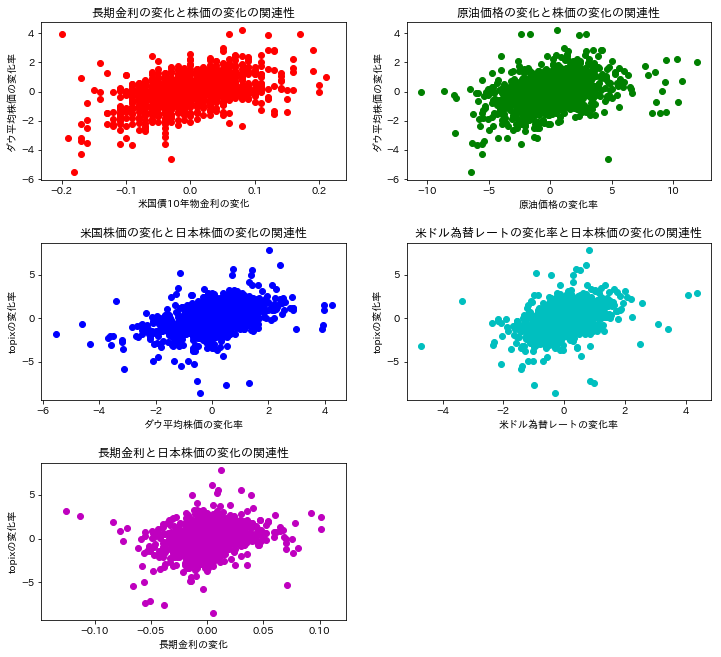

In [22]:
##マーケットデータの関係性を可視化
fig = plt.figure(figsize=(12.0, 11.0))
plt.subplots_adjust(wspace=0.2, hspace=0.4)   #余白を設定
colorlist = ["r", "g", "b", "c", "m", "y", "k", "w"]
ax = fig.add_subplot(3, 2, 1)
plt.scatter(market_df["us_diff"], market_df["dj_diff"], color=colorlist[0])
plt.title("長期金利の変化と株価の変化の関連性")
plt.xlabel("米国債10年物金利の変化")
plt.ylabel("ダウ平均株価の変化率")

ax = fig.add_subplot(3, 2, 2)
plt.scatter(market_df["wti_diff"], market_df["dj_diff"], color=colorlist[1])
plt.title("原油価格の変化と株価の変化の関連性")
plt.xlabel("原油価格の変化率")
plt.ylabel("ダウ平均株価の変化率")

ax = fig.add_subplot(3, 2, 3)
plt.scatter(market_df["dj_diff"], market_df["ETF_diff"], color=colorlist[2])
plt.title("米国株価の変化と日本株価の変化の関連性")
plt.xlabel("ダウ平均株価の変化率")
plt.ylabel("topixの変化率")

ax = fig.add_subplot(3, 2, 4)
plt.scatter(market_df["USD_diff"], market_df["ETF_diff"], color=colorlist[3])
plt.title("米ドル為替レートの変化率と日本株価の変化の関連性")
plt.xlabel("米ドル為替レートの変化率")
plt.ylabel("topixの変化率")

ax = fig.add_subplot(3, 2, 5)
plt.scatter(market_df["jp_diff"], market_df["ETF_diff"], color=colorlist[4])
plt.title("長期金利と日本株価の変化の関連性")
plt.xlabel("長期金利の変化")
plt.ylabel("topixの変化率")

In [23]:
####Hierarchical structured latent factor modelでパラメータを推定####
##ベイジアン多変量回帰モデルをギブスサンプリングする関数
def rmultireg(Y, X, inv_XXV, XY, Cov, ADelta, Deltabar, V, nu, n, col, k):
    #事後分布のパラメータを設定
    beta_mu = np.dot(inv_XXV, XY + np.dot(ADelta, Deltabar)).T.reshape(-1)   #平均ベクトル
    sigma = np.kron(Cov, inv_XXV)   #分散共分散行列

    #パラメータをサンプリング
    beta_vec = np.random.multivariate_normal(beta_mu, sigma, 1)
    beta = beta_vec.reshape(col, k, order='F')   #回帰行列に変換

    
    ##逆ウィシャート分布から分散共分散行列をサンプリング
    #モデル誤差を設定
    mu = np.dot(X, beta)
    er = Y - mu

    #逆ウィシャート分布のパラメータ
    IW_R = np.dot(er.T, er) + V
    Sn = n + nu

    #パラメータをサンプリング
    Cov = scipy.stats.invwishart.rvs(Sn, IW_R, 1)
    return beta, Cov

In [24]:
##アルゴリズムの設定
k = 15
R = 250
keep = 1
burnin = int(50/keep)
iter = 0
disp = 10

In [25]:
##データの設定
#入力変数の設定
market_df_all = pd.merge(target_date[["date"]], market_df, on="date", how="left")
market_df1 = pd.merge(target_date1[["date"]], market_df, on="date", how="left")
market_df2 = pd.merge(target_date2[["date"]], market_df, on="date", how="left")
print([market_df1.shape[0], target_date1.shape[0], np.sum(pd.isna(market_df1["ETF_price"]))])   
print([market_df2.shape[0], target_date2.shape[0], np.sum(pd.isna(market_df2["ETF_price"]))])
x1 = np.array(market_df1[["USD_diff", "EUR_diff", "ff_diff", "us_diff", "call_diff", "jp_diff", "dj_diff", "ETF_diff", "wti_diff"]])
x2 = np.array(market_df2[["USD_diff", "EUR_diff", "ff_diff", "us_diff", "call_diff", "jp_diff", "dj_diff", "ETF_diff", "wti_diff"]])
x1 = np.hstack((np.repeat(1, N1)[:, np.newaxis], x1))
x2 = np.hstack((np.repeat(1, N2)[:, np.newaxis], x2))
x_col = x1.shape[1]
k_vec = np.repeat(1, k)
x_vec = np.repeat(1, x_col)

#応答変数の設定
y = np.array(target_panel["diff_ratio"] * 100)
y1 = np.array(target_panel1["diff_ratio"] * 100)
y2 = np.array(target_panel2["diff_ratio"] * 100)

#企業一覧
pd.unique(target_panel["銘柄名"])

[751261, 751261, 0]
[187816, 187816, 0]


array(['日本水産', 'マルハニチロ', '国際石油開発帝石', '大成建設', '大林組', '清水建設', '長谷工Corp.',
       '鹿島', '西松建設', '前田建設工業', '奥村組', '戸田建設', '大東建託', '前田道路', '東亜建設工業',
       '五洋建設', '住友林業', '大和ハウス工業', '積水ハウス', 'きんでん', '日揮', '森永製菓', '森永乳業',
       'ヤクルト本社', '明治HD', '雪印メグミルク', '日本ハム', '伊藤ハム米久HD', 'ＡＬＳＯＫ', 'いちご',
       'サッポロHD', 'アサヒグループHD', 'キリンHD', 'サントリー食品インターナショナル', '伊藤園', 'ローソン',
       'エービーシー・マート', 'アスクル', '日本マクドナルドHD', '双日', '味の素', 'キユーピー', 'カゴメ',
       'ニチレイ', '東洋水産', '日清食品HD', 'ＪＴ', 'グンゼ', 'ヒューリック', 'ビックカメラ',
       'Ｊ．フロント_リテイリング', 'マツモトキヨシHD', '三越伊勢丹HD', '東洋紡', '日清紡HD', 'クラボウ',
       'ダイワボウHD', '日東紡', '野村不動産HD', 'ユニゾHD', '東急不動産HD', 'セブン＆アイ・HD', '帝人',
       '東レ', 'クラレ', '旭化成', 'ＳＵＭＣＯ', 'アツギ', 'ＬＩＸＩＬビバ', 'インターネットイニシアティブ',
       '王子HD', '日本製紙', '三菱製紙', '北越紀州製紙', '中越パルプ工業', '大王製紙', 'ＬＩＮＥ',
       'レンゴー', '昭和電工', '住友化学', '日産化学工業', '石原産業', '日本曹達', '東ソー', '東亞合成',
       'デンカ', 'イビデン', '信越化学工業', '堺化学工業', 'エア・ウォーター', '大陽日酸', '日本触媒',
       'カネカ', '協和発酵キリン', '三菱ガス化学', '三井化学', 'ＪＳＲ', '三菱ケミカルHD', 'ダイセル',
 

In [26]:
##株価とマーケット指標との関連
#相関をチェック
temp_df = pd.concat([target_panel[["コード", "銘柄名", "業種", "diff_ratio"]], 
                     market_df_all[["USD_diff", "EUR_diff", "ff_diff", "us_diff", "call_diff", "jp_diff", "dj_diff", 
                                    "ETF_diff", "wti_diff"]]], axis=1)
index = np.where(temp_df["銘柄名"]=="住友金属鉱山")[0]
temp_df.iloc[index][["diff_ratio", "USD_diff", "EUR_diff", "ff_diff", "us_diff", "call_diff", "jp_diff", "dj_diff", 
                     "ETF_diff", "wti_diff"]].corr()

,diff_ratio,USD_diff,EUR_diff,ff_diff,us_diff,call_diff,jp_diff,dj_diff,ETF_diff,wti_diff
diff_ratio,1.000000,0.177683,0.281414,0.002614,0.206936,-0.012798,0.164216,0.389697,0.649243,0.283224
USD_diff,0.177683,1.000000,0.620615,-0.009672,0.419226,0.020616,0.232583,0.272120,0.383910,0.069987
EUR_diff,0.281414,0.620615,1.000000,-0.008109,0.378491,-0.009177,0.240297,0.400895,0.368898,0.205048
ff_diff,0.002614,-0.009672,-0.008109,1.000000,0.028643,-0.086784,0.026238,-0.004907,-0.011108,-0.064212
us_diff,0.206936,0.419226,0.378491,0.028643,1.000000,0.033392,0.355277,0.453682,0.270625,0.250365
call_diff,-0.012798,0.020616,-0.009177,-0.086784,0.033392,1.000000,-0.008282,-0.000860,-0.007023,-0.014965
jp_diff,0.164216,0.232583,0.240297,0.026238,0.355277,-0.008282,1.000000,0.125111,0.270328,0.047327
dj_diff,0.389697,0.272120,0.400895,-0.004907,0.453682,-0.000860,0.125111,1.000000,0.441262,0.344914
ETF_diff,0.649243,0.383910,0.368898,-0.011108,0.270625,-0.007023,0.270328,0.441262,1.000000,0.187016
wti_diff,0.283224,0.069987,0.205048,-0.064212,0.250365,-0.014965,0.047327,0.344914,0.187016,1.000000


Text(0, 0.5, '株価の変化率')

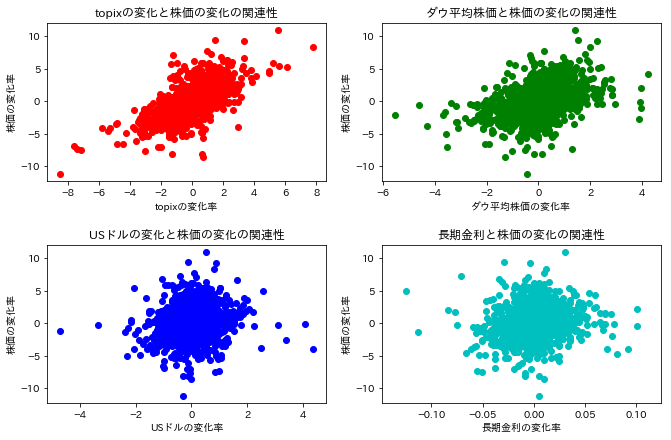

In [ ]:
#散布図をチェック
fig = plt.figure(figsize=(11.0, 7.0))
plt.subplots_adjust(wspace=0.2, hspace=0.4)   #余白を設定
colorlist = ["r", "g", "b", "c", "m", "y", "k", "w"]
ax = fig.add_subplot(2, 2, 1)
plt.scatter(market_df_all.iloc[index]["ETF_diff"], y[index], color=colorlist[0])
plt.title("topixの変化と株価の変化の関連性")
plt.xlabel("topixの変化率")
plt.ylabel("株価の変化率")

ax = fig.add_subplot(2, 2, 2)
plt.scatter(market_df_all.iloc[index]["dj_diff"], y[index], color=colorlist[1])
plt.title("ダウ平均株価と株価の変化の関連性")
plt.xlabel("ダウ平均株価の変化率")
plt.ylabel("株価の変化率")

ax = fig.add_subplot(2, 2, 3)
plt.scatter(market_df_all.iloc[index]["USD_diff"], y[index], color=colorlist[2])
plt.title("USドルの変化と株価の変化の関連性")
plt.xlabel("USドルの変化率")
plt.ylabel("株価の変化率")

ax = fig.add_subplot(2, 2, 4)
plt.scatter(market_df_all.iloc[index]["jp_diff"], y[index], color=colorlist[3])
plt.title("長期金利と株価の変化の関連性")
plt.xlabel("長期金利の変化率")
plt.ylabel("株価の変化率")

In [ ]:
##事前分布の設定
#階層モデルの事前分布
delta1 = np.repeat(0, x_col)
delta2 = np.repeat(0, k)
nu1 = 1; nu2 = 1
V1 = 0.1 * np.diag(np.ones(x_col))
V2 = 0.1 * np.diag(np.ones(k))
s01 = 0.1
s01 = 0.1

#モデルパラメータの事前分布
tau = 100 
s02 = 1.0
v02 = 1.0

In [ ]:
##初期値の設定
#階層モデルの初期値
alpha = np.repeat(0.0, x_col)
alpha_u = np.repeat(0.0, k)
alpha_v = np.repeat(0.0, k)
Cov = np.diag(np.repeat(1.0, x_col))
Cov_u = np.diag(np.repeat(1.0, k))
Cov_v = np.diag(np.repeat(0.5, k))
inv_Cov = np.linalg.inv(Cov)
inv_Cov_u = np.linalg.inv(Cov_u)
inv_Cov_v = np.linalg.inv(Cov_v)

#モデルパラメータの初期値
beta = np.array(np.mean(y1))
theta = np.random.multivariate_normal(alpha, np.diag(np.repeat(0.01, x_col)), n)
theta_u = np.random.multivariate_normal(alpha_u, np.diag(np.repeat(0.01, k)), n)
theta_v = np.vstack((np.random.multivariate_normal(alpha_v, np.diag(np.repeat(0.01, k)), news_na), np.repeat(1, k)))
Sigma = np.sqrt(np.sum(np.power(y1 - beta, 2)) / N1)

#期待値の初期値
theta_vec = theta[company_id1, ]
theta_u1 = theta_u[company_id1, ]
theta_v1 = np.zeros((N1, k))
for j in range(date_max):
    theta_v1[allocation_index1[j], ] += theta_v[allocation_item1[j], ]
theta_mu = np.sum(x1 * theta_vec, axis=1)
uv = np.sum(theta_v1 * theta_u1, axis=1)
mu = beta + theta_mu + uv

In [ ]:
##パラメータの格納用配列
COV = np.zeros((x_col, x_col, int(R/keep)))
COV_U = np.zeros((k, k, int(R/keep)))
COV_V = np.zeros((k, k, int(R/keep)))
BETA = np.repeat(0.0, int(R/keep))
THETA =np.zeros((n, x_col, int(R/keep)))
THETA_U = np.zeros((n, k, int(R/keep)))
THETA_V = np.zeros((news_na, k, int(R/keep)))
SIGMA = np.repeat(0.0, int(R/keep))

In [ ]:
##対数尤度の基準値
#1パラメータモデルの対数尤度
LLst = np.sum(scipy.stats.norm.logpdf(y1, np.mean(y1), np.std(y1)))
print(LLst)

#初期値の対数尤度
LL = np.sum(scipy.stats.norm.logpdf(y1, mu, Sigma))
print(LL)

-1638362.1295101687
-1657383.1560431856


In [ ]:
####ギブスサンプリングでパラメータをサンプリング####
for rp in range(R):
    ##モデル期待値をサンプリング
    #モデル誤差を定義
    Sigma_sq = np.power(Sigma, 2)
    er_y = y1 - theta_mu - uv

    #正規分布から期待値をサンプリング
    weights = np.power(tau, 2) / (Sigma_sq/N1 + np.power(tau, 2))
    mu_par = weights * np.mean(er_y)
    beta = np.random.normal(mu_par, weights*Sigma_sq/N1, 1)

    #逆ガンマ分布から標準偏差をサンプリング
    er_y = y1 - beta - theta_mu - uv
    s1 = np.sum(np.power(er_y, 2)) + s01
    s2 = N1 + s02
    Sigma = np.sqrt(1/np.random.gamma(s2/2, 1/(s1/2), 1))


    ##企業の回帰ベクトルと特徴ベクトルをサンプリング
    #モデル誤差を定義
    er_y = y1 - beta 
    inv_Cov0 = np.diag(np.append(np.diag(inv_Cov), np.diag(inv_Cov_u)))

    for i in range(n):
        #事後分布のパラメータ
        index = company_index1[i]    
        x11 = np.hstack((x1[index, ], theta_v1[index, ])); y11 = er_y[index]
        xy = np.dot(x11.T, y11)
        xxv = np.dot(x11.T, x11) + inv_Cov0
        inv_xxv = np.linalg.inv(xxv)
        theta_par = np.dot(inv_xxv, xy + np.dot(inv_Cov0, np.append(alpha, alpha_u)))

        #多変量正規分布からパラメータをサンプリング
        theta_temp = np.random.multivariate_normal(theta_par, Sigma_sq*inv_xxv, 1).reshape(-1)
        theta[i, ] = theta_temp[np.arange(x_col)]
        theta_u[i, ] = theta_temp[x_col+np.arange(k)]

    #データの更新
    theta_vec = theta[company_id1, ]
    theta_mu = np.sum(x1 * theta_vec, axis=1)
    theta_u1 = theta_u[company_id1, ]
    uv = np.sum(theta_v1 * theta_u1, axis=1)

    ##ニュースの特徴ベクトルをサンプリング
    #モデル誤差を定義
    er_y = y1 - beta  - theta_mu

    for i in range(news_na):
        #事後分布のパラメータ
        index = news_index1[i]; uv_target = uv[index]
        x11 = theta_u1[index, ]; uv_rid = np.sum(x11 * theta_v[i, ], axis=1)
        y11 = er_y[index] - uv_target + uv_rid
        xy = np.dot(x11.T, y11)
        xxv = np.dot(x11.T, x11) + inv_Cov_v
        inv_xxv = np.linalg.inv(xxv)
        theta_par = np.dot(inv_xxv, xy + np.dot(inv_Cov_v, alpha_v))

        #多変量正規分布からパラメータをサンプリング
        theta_v[i, ] = np.random.multivariate_normal(theta_par, Sigma_sq*inv_xxv, 1).reshape(-1)
        uv[index] = uv_target - uv_rid + np.sum(x11 * theta_v[i, ], axis=1)
        
    #期待値を更新
    theta_v1 = np.zeros((N1, k))
    for j in range(date_max):
        theta_v1[allocation_index1[j], ] += theta_v[allocation_item1[j], ]
    uv = np.sum(theta_v1 * theta_u1, axis=1)
    mu = beta + theta_mu + uv

    
    ##階層モデルのパラメータをサンプリング
    #回帰ベクトルの階層モデルの分散共分散行列をサンプリング
    er = theta - np.mean(theta, axis=0)
    IW_R = np.dot(er.T, er) + V1
    Sn = n + nu1
    Cov = np.diag(np.diag(scipy.stats.invwishart.rvs(Sn, IW_R, 1)))
    inv_Cov = np.linalg.inv(Cov)

    #企業特徴ベクトルの階層モデルの分散共分散行列をサンプリング
    er = theta_u - np.mean(theta_u, axis=0)
    IW_R = np.dot(er.T, er) + V2
    Sn = n + nu1
    Cov_u = np.diag(np.diag(scipy.stats.invwishart.rvs(Sn, IW_R, 1)))
    inv_Cov_u = np.linalg.inv(Cov_u)

    #ニュース特徴ベクトルの階層モデルの分散共分散行列をサンプリング
    #er = theta_v - np.mean(theta_v, axis=0)
    #IW_R = np.dot(er.T, er) + V2
    #Sn = n + nu1
    #Cov_v = np.diag(np.diag(scipy.stats.invwishart.rvs(Sn, IW_R, 1)))
    #inv_Cov_v = np.linalg.inv(Cov_v)


    ##サンプリング結果の格納と表示
    if rp%keep==0:
        mkeep = int(rp/keep)
        COV[:, :, mkeep] = Cov
        COV_U[:, :, mkeep] = Cov_u
        COV_V[:, :, mkeep] = Cov_v
        BETA[mkeep] = beta
        THETA[:, :, mkeep] = theta
        THETA_U[:, :, mkeep] = theta_u
        THETA_V[:, :, mkeep] = theta_v[:news_na, ]
        SIGMA[mkeep] = Sigma
        
    if rp%disp==0:
        #学習データに対するRMSE
        RMSE1 = np.sqrt(np.sum(np.power(y1 - mu, 2)) / N1)

        #テストデータに対するRMSE
        theta_u2 = theta_u[company_id2, ]
        theta_v2 = np.zeros((N2, k))
        for j in range(date_max):
            theta_v2[allocation_index2[j], ] += theta_v[allocation_item2[j], ]
        mu2 = beta + np.sum(x2 * theta[company_id2, ], axis=1) + np.sum(theta_v2 * theta_u2, axis=1)
        RMSE2 = np.sqrt(np.sum(np.power(y2 - mu2, 2)) / N2)

        #サンプリング結果の表示
        print(rp)
        print([RMSE1, RMSE2])

0
[1.685095450504575, 1.73891802239283]
10
[1.4976431458970734, 1.6726290802283008]
